In [14]:
import scanpy as sc
import torch
import seaborn as sns
import os
import scvi
import pandas as pd
import numpy as np

In [15]:
torch.has_cuda

True

In [16]:
scvi.settings.seed = 0

Global seed set to 0


In [17]:
# ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
# ribo_genes = pd.read_table(ribo_url, skiprows=2, header=None)

# 文件的头两行没用，所以跳过2行
ribo_genes = pd.read_table('./KEGG_RIBOSOME.v2023.1.Hs.txt', skiprows=2, header=None)
ribo_genes[0].values

array(['FAU', 'MRPL13', 'RPL10', 'RPL10A', 'RPL10L', 'RPL11', 'RPL12',
       'RPL13', 'RPL13A', 'RPL14', 'RPL15', 'RPL17', 'RPL18', 'RPL18A',
       'RPL19', 'RPL21', 'RPL22', 'RPL22L1', 'RPL23', 'RPL23A', 'RPL24',
       'RPL26', 'RPL26L1', 'RPL27', 'RPL27A', 'RPL28', 'RPL29', 'RPL3',
       'RPL30', 'RPL31', 'RPL32', 'RPL34', 'RPL35', 'RPL35A', 'RPL36',
       'RPL36A', 'RPL36AL', 'RPL37', 'RPL37A', 'RPL38', 'RPL39', 'RPL3L',
       'RPL4', 'RPL41', 'RPL5', 'RPL6', 'RPL7', 'RPL7A', 'RPL8', 'RPL9',
       'RPLP0', 'RPLP1', 'RPLP2', 'RPS10', 'RPS11', 'RPS12', 'RPS13',
       'RPS15', 'RPS15A', 'RPS16', 'RPS17', 'RPS18', 'RPS19', 'RPS2',
       'RPS20', 'RPS21', 'RPS23', 'RPS24', 'RPS25', 'RPS26', 'RPS27',
       'RPS27A', 'RPS27L', 'RPS28', 'RPS29', 'RPS3', 'RPS3A', 'RPS4X',
       'RPS4Y1', 'RPS5', 'RPS6', 'RPS7', 'RPS8', 'RPS9', 'RPSA',
       'RSL24D1', 'RSL24D1P11', 'UBA52'], dtype=object)

In [18]:
file_path = 'dataset-mouse-gene/new/'
save_path = 'dataset-mouse-gene/'

In [19]:
def pp(csv_path):
    adata = sc.read_csv(csv_path)

    # 使读入的细胞名称进行编号，例如多个 A 细胞则编号成 A-1, A-2
    adata.obs_names_make_unique()
    adata.var_names_make_unique()

    # 过滤至少超过在10个细胞中表达的基因
    # sc.pp.filter_genes(adata, min_cells = 10)
    # sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

    # 训练模型
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()

    # 计算doublet
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()

    # 标记doublet
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    # df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
    # doublets = df[(df.prediction == 'doublet')]
    sns.displot(df[df.prediction == 'doublet'], x = 'dif')

    adata1 = sc.read_csv(csv_path)
    adata1.var_names_make_unique()
    adata1.obs_names_make_unique()
    adata1.obs['Sample'] = (csv_path.split('_')[0]).split('/')[2] #'raw_counts/GSM5226574_C51ctr_raw_counts.csv'

    # 筛去 doublet
    adata1.obs['doublet'] = adata1.obs.index.isin(doublets.index)
    adata1 = adata1[~adata1.obs.doublet]


    # sc.pp.filter_cells(adata1, min_genes=200) #get rid of cells with fewer than 200 genes
    #sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells

    adata1.var['mt'] = adata1.var.index.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    adata1.var['ribo'] = adata1.var_names.isin(ribo_genes[0].values)

    sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata1.obs.n_genes_by_counts.values, .98)

    adata2 = adata1[adata1.obs.n_genes_by_counts < upper_lim]

    # 过滤线粒体 MT和血红蛋白 ribo
    # adata2 = adata2[adata2.obs.pct_counts_mt < 20]
    # adata2 = adata2[adata2.obs.pct_counts_ribo < 2]

    return adata2

C:\Users\25363\anaconda3\envs\scVI\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\25363\anaconda3\envs\scVI\lib\site-packages\lightning\pytorch\loops\fit_loop.py:280: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:49<00:00,  8.58it/s, v_num=1, train_loss_step=4.26e+3, train_loss_epoch=4.07e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:49<00:00,  8.08it/s, v_num=1, train_loss_step=4.26e+3, train_loss_epoch=4.07e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 347/400:  87%|████████▋ | 347/400 [00:20<00:03, 16.57it/s, v_num=1, train_loss_step=0.196, train_loss_epoch=0.208]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.269. Signaling Trainer to stop.


C:\Users\25363\anaconda3\envs\scVI\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\25363\anaconda3\envs\scVI\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\25363\AppData\Local\Temp\ipykernel_3288\3247757311.py:43: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata1.var['mt'] = adata1.var.index.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
C:\Users\25363\anaconda3\envs\scVI\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, us

Epoch 400/400: 100%|██████████| 400/400 [00:58<00:00,  6.46it/s, v_num=1, train_loss_step=5.65e+3, train_loss_epoch=5.11e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:58<00:00,  6.84it/s, v_num=1, train_loss_step=5.65e+3, train_loss_epoch=5.11e+3]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [00:30<00:00, 14.92it/s, v_num=1, train_loss_step=0.366, train_loss_epoch=0.253]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:30<00:00, 13.32it/s, v_num=1, train_loss_step=0.366, train_loss_epoch=0.253]


C:\Users\25363\anaconda3\envs\scVI\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\25363\anaconda3\envs\scVI\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\25363\AppData\Local\Temp\ipykernel_3288\3247757311.py:43: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata1.var['mt'] = adata1.var.index.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


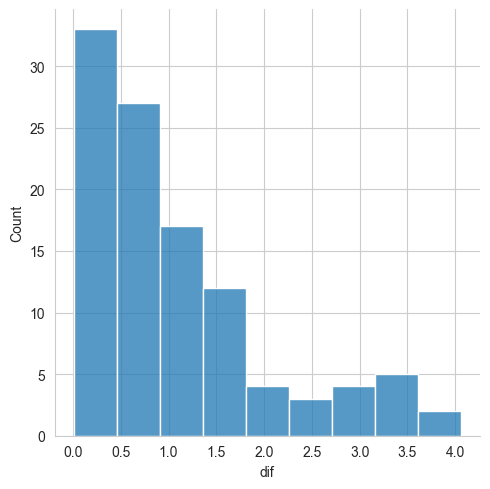

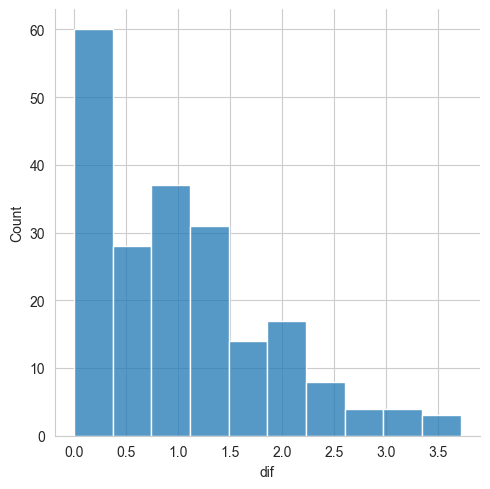

In [20]:
out = []
for file in os.listdir(file_path):
    out.append(pp(file_path + file))

In [21]:
out

[View of AnnData object with n_obs × n_vars = 761 × 14878
     obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
     var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts',
 View of AnnData object with n_obs × n_vars = 951 × 14878
     obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
     var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts']

In [22]:
# adata3 = sc.concat(out)
adata3 = sc.concat(out, axis=0)
# adata3 = out[1]
adata3

AnnData object with n_obs × n_vars = 1712 × 14878
    obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'

In [23]:
# 给每个区分了名称的细胞标签重新打上标签
cell_label = adata3.obs.index.str.split('#').str[0]
adata3.obs['cell_label'] = cell_label

In [24]:
adata3.obs

,Sample,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,cell_label
delta#1-1,GSM2230761,False,2548,7640.0,0.0,0.0,0.0,0.0,delta
beta#1-1,GSM2230761,False,2828,11616.0,0.0,0.0,0.0,0.0,beta
beta#1-2,GSM2230761,False,2534,9066.0,0.0,0.0,0.0,0.0,beta
ductal#1-1,GSM2230761,False,2863,7054.0,0.0,0.0,0.0,0.0,ductal
ductal#1-2,GSM2230761,False,2837,7175.0,0.0,0.0,0.0,0.0,ductal
...,...,...,...,...,...,...,...,...,...
beta#2-549,GSM2230762,False,805,2115.0,0.0,0.0,0.0,0.0,beta
beta#2-550,GSM2230762,False,778,1864.0,0.0,0.0,0.0,0.0,beta
ductal#2-37,GSM2230762,False,1010,1714.0,0.0,0.0,0.0,0.0,ductal
quiescent_stellate#2-17,GSM2230762,False,888,1502.0,0.0,0.0,0.0,0.0,quiescent_stellate


In [25]:
adata3.var

""
0610007P14Rik
0610009B22Rik
0610009E02Rik
0610009L18Rik
0610009O20Rik
...
Zyg11b
Zyx
Zzef1
Zzz3


In [26]:
adata3.write_h5ad(save_path + 'pre-read/combined-no-filtration.h5ad')

# 重载数据

In [27]:
adata3 = sc.read_h5ad(save_path + '/pre-read/combined-no-filtration.h5ad')

In [28]:
# 稀疏矩阵存储
from scipy.sparse import csr_matrix

adata3.X = csr_matrix(adata3.X)
adata3.X

<1712x14878 sparse matrix of type '<class 'numpy.float32'>'
	with 2619121 stored elements in Compressed Sparse Row format>

In [29]:
adata3.obs

,Sample,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,cell_label
delta#1-1,GSM2230761,False,2548,7640.0,0.0,0.0,0.0,0.0,delta
beta#1-1,GSM2230761,False,2828,11616.0,0.0,0.0,0.0,0.0,beta
beta#1-2,GSM2230761,False,2534,9066.0,0.0,0.0,0.0,0.0,beta
ductal#1-1,GSM2230761,False,2863,7054.0,0.0,0.0,0.0,0.0,ductal
ductal#1-2,GSM2230761,False,2837,7175.0,0.0,0.0,0.0,0.0,ductal
...,...,...,...,...,...,...,...,...,...
beta#2-549,GSM2230762,False,805,2115.0,0.0,0.0,0.0,0.0,beta
beta#2-550,GSM2230762,False,778,1864.0,0.0,0.0,0.0,0.0,beta
ductal#2-37,GSM2230762,False,1010,1714.0,0.0,0.0,0.0,0.0,ductal
quiescent_stellate#2-17,GSM2230762,False,888,1502.0,0.0,0.0,0.0,0.0,quiescent_stellate


In [30]:
adata3.var

""
0610007P14Rik
0610009B22Rik
0610009E02Rik
0610009L18Rik
0610009O20Rik
...
Zyg11b
Zyx
Zzef1
Zzz3


In [31]:
adata3.obs.groupby('Sample').count()
sc.pp.filter_genes(adata3, min_cells=30)
adata3

AnnData object with n_obs × n_vars = 1712 × 10327
    obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cell_label'
    var: 'n_cells'

In [32]:
# layers里的counts存储的是X的数值备份
adata3.layers['counts'] = adata3.X.copy()
# adata3.layers['counts']
adata3

AnnData object with n_obs × n_vars = 1712 × 10327
    obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cell_label'
    var: 'n_cells'
    layers: 'counts'

In [33]:
sc.pp.normalize_total(adata3, target_sum=1e4)
sc.pp.log1p(adata3)
adata3.raw = adata3
adata3

AnnData object with n_obs × n_vars = 1712 × 10327
    obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cell_label'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [34]:
adata3.X.sum(axis=1)

matrix([[2858.0647],
        [2667.3164],
        [2708.1562],
        ...,
        [2173.4744],
        [2001.0315],
        [1953.1965]], dtype=float32)

In [35]:
adata3.layers["counts"]

<1712x10327 sparse matrix of type '<class 'numpy.float32'>'
	with 2572478 stored elements in Compressed Sparse Row format>

In [36]:
adata3.raw

In [37]:
adata3.obs

,Sample,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,cell_label
delta#1-1,GSM2230761,False,2548,7640.0,0.0,0.0,0.0,0.0,delta
beta#1-1,GSM2230761,False,2828,11616.0,0.0,0.0,0.0,0.0,beta
beta#1-2,GSM2230761,False,2534,9066.0,0.0,0.0,0.0,0.0,beta
ductal#1-1,GSM2230761,False,2863,7054.0,0.0,0.0,0.0,0.0,ductal
ductal#1-2,GSM2230761,False,2837,7175.0,0.0,0.0,0.0,0.0,ductal
...,...,...,...,...,...,...,...,...,...
beta#2-549,GSM2230762,False,805,2115.0,0.0,0.0,0.0,0.0,beta
beta#2-550,GSM2230762,False,778,1864.0,0.0,0.0,0.0,0.0,beta
ductal#2-37,GSM2230762,False,1010,1714.0,0.0,0.0,0.0,0.0,ductal
quiescent_stellate#2-17,GSM2230762,False,888,1502.0,0.0,0.0,0.0,0.0,quiescent_stellate


In [38]:
scvi.model.SCVI.setup_anndata(adata3, layer="counts",
                              categorical_covariate_keys=["Sample"],
                              continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])
# scvi.model.SCVI.setup_anndata(adata3)
model = scvi.model.SCVI(adata3)
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [01:21<00:00,  5.38it/s, v_num=1, train_loss_step=4.51e+3, train_loss_epoch=4.72e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:21<00:00,  4.91it/s, v_num=1, train_loss_step=4.51e+3, train_loss_epoch=4.72e+3]


In [39]:
# 潜在的低维表示
adata3.obsm['X_scVI'] = model.get_latent_representation()
# 获取正则化后的表达
adata3.layers['scvi_normalized'] = model.get_normalized_expression(library_size=1e4)

In [40]:
adata3.obsm['X_scVI']

array([[ 0.9145378 , -2.6127145 ,  1.6962485 , ..., -0.9457644 ,
         0.20227838,  2.3744335 ],
       [-1.785511  ,  1.6887118 ,  2.8549347 , ...,  2.488152  ,
         1.0684826 ,  0.7214409 ],
       [-1.7149239 ,  0.8974848 ,  0.67479825, ..., -1.703937  ,
         0.63801205,  0.5369009 ],
       ...,
       [-2.1082258 ,  3.3243248 ,  0.8842559 , ..., -0.42742372,
         1.158363  ,  1.0393018 ],
       [ 0.65050566,  1.9255508 , -0.3466506 , ...,  2.8278985 ,
        -2.2720275 , -0.274109  ],
       [-1.8966384 ,  1.1537211 , -0.72027284, ...,  2.4997048 ,
        -2.066842  , -3.4001322 ]], dtype=float32)

In [41]:
adata3.obsm['scvi_normalized'] = adata3.layers['scvi_normalized']

In [42]:
adata3.obsm['scvi_normalized'].sum(axis=1)

array([10000.   ,  9999.999, 10000.   , ..., 10000.   , 10000.001,
       10000.   ], dtype=float32)

In [43]:
# use_rep参数使用 X或者任何 .obsm的键都有效
sc.pp.neighbors(adata3, use_rep='X_scVI')
# sc.pp.neighbors(adata3, use_rep='scvi_normalized')
# sc.pp.neighbors(adata3, use_rep='X')

C:\Users\25363\anaconda3\envs\scVI\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\25363\anaconda3\envs\scVI\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\25363\anaconda3\envs\scVI\lib\site-packages\umap\distances.py:1086: NumbaDeprecatio

In [44]:
adata3.obs

,Sample,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,cell_label,_scvi_batch,_scvi_labels
delta#1-1,GSM2230761,False,2548,7640.0,0.0,0.0,0.0,0.0,delta,0,0
beta#1-1,GSM2230761,False,2828,11616.0,0.0,0.0,0.0,0.0,beta,0,0
beta#1-2,GSM2230761,False,2534,9066.0,0.0,0.0,0.0,0.0,beta,0,0
ductal#1-1,GSM2230761,False,2863,7054.0,0.0,0.0,0.0,0.0,ductal,0,0
ductal#1-2,GSM2230761,False,2837,7175.0,0.0,0.0,0.0,0.0,ductal,0,0
...,...,...,...,...,...,...,...,...,...,...,...
beta#2-549,GSM2230762,False,805,2115.0,0.0,0.0,0.0,0.0,beta,0,0
beta#2-550,GSM2230762,False,778,1864.0,0.0,0.0,0.0,0.0,beta,0,0
ductal#2-37,GSM2230762,False,1010,1714.0,0.0,0.0,0.0,0.0,ductal,0,0
quiescent_stellate#2-17,GSM2230762,False,888,1502.0,0.0,0.0,0.0,0.0,quiescent_stellate,0,0


         Falling back to preprocessing with `sc.pp.pca` and default params.


C:\Users\25363\anaconda3\envs\scVI\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


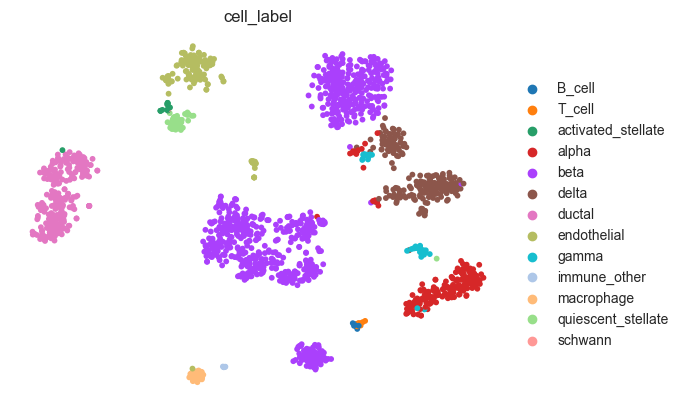

In [45]:
# tsne降维做聚类
sc.tl.tsne(adata3)
# sc.tl.leiden(adata3, resolution=1)
sc.pl.tsne(adata3, color=['cell_label'], frameon=False)

In [46]:
adata3.obsm['X_tsne']

array([[ 35.693737 ,   4.5445094],
       [-20.305834 , -20.156519 ],
       [-20.472551 , -18.385815 ],
       ...,
       [-48.575592 ,   8.181451 ],
       [-29.341682 ,  21.085535 ],
       [-50.694202 ,  -2.7687242]], dtype=float32)

In [47]:
tsne_0 = adata3.obsm['X_tsne'][:, 0]
tsne_1 = adata3.obsm['X_tsne'][:, 1]

In [48]:
adata3.obs['tsne_0'] = tsne_0
adata3.obs['tsne_1'] = tsne_1

# Find markers/ label cell types

In [49]:
# sc.tl.leiden(adata3, resolution=1)
sc.tl.rank_genes_groups(adata3, 'cell_label')

ValueError: Could not calculate statistics for groups schwann since they only contain one sample.

In [ ]:
#sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

markers = sc.get.rank_genes_groups_df(adata3, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

In [ ]:
# markers_scvi = model.differential_expression(groupby = 'leiden')
markers_scvi = model.differential_expression(groupby='cell_label')
markers_scvi

In [ ]:
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi.lfc_mean > .5)]
markers_scvi

In [ ]:
adata3.obs

In [ ]:
sc.pl.tsne(adata3, color = ['cell_label', 'Sample'], frameon = False)
# , legend_loc = "on data"

In [ ]:
sc.pl.tsne(adata3, color=['cell_label'], frameon=False)

In [ ]:
# 将Marker Gene存到数据的uns中，uns是非结构化数据的意思
adata3.uns['markers_scvi'] = markers_scvi
adata3.uns['markers'] = markers

In [ ]:
adata3.write_h5ad(save_path + '/pre-read/integrated-no-filtration.h5ad')